In this exercise, you'll predict house prices using your model. Compare your work to [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/6.solution_making_predictions.ipynb).

* Load the **housing prices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.

In [43]:
######################################
######   Notice the new imports  #####
######################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

houses_df.head(3)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500


In [44]:
# Replace missing numerical values with the mean and missing categoricals ('None') with 'No--' 
# -- = first to letters of feature, ie. NoFe = 'no fence' 
# and the lone missing electrical value with house_df.electrical.mode()

houses_df['electrical'].fillna(str(houses_df['electrical'].mode()), inplace=True)

for column_name in houses_df.columns[3:]:
    for idx, value in enumerate(houses_df[column_name]):
        if pd.isna(value):
            try:
                houses_df[column_name].fillna(houses_df[column_name].mean(), inplace=True)
            except:
                houses_df[column_name].fillna('No' + column_name[:2].capitalize(), inplace=True)

In [45]:
# Creating our dummy variables
columns = ['alley','poolqc','garagetype']

# Create a dataframe with added dummy features
houses_df_dummies = pd.get_dummies(houses_df, columns=columns, drop_first=True)
dummy_columns = [c for c in houses_df_dummies.columns if any([c.startswith(n) for n in columns])]
dummy_columns

['alley_NoAl',
 'alley_Pave',
 'poolqc_Fa',
 'poolqc_Gd',
 'poolqc_NoPo',
 'garagetype_Attchd',
 'garagetype_Basment',
 'garagetype_BuiltIn',
 'garagetype_CarPort',
 'garagetype_Detchd',
 'garagetype_NoGa']

In [65]:
# Using the features of our most successful model so far (R-squared of 0.516)
features = ['alley_Pave','poolqc_Fa','poolqc_Gd','poolqc_NoPo','garagetype_Attchd','garagetype_BuiltIn',
            'garagetype_NoGa','lotarea','totalbsmtsf']

# X is the feature set we are using to predict saleprice
X = houses_df_dummies[features]
Y = houses_df_dummies.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print(f'Training set observation count: {X_train.shape[0]}')
print(f'Testing set observation count: {X_test.shape[0]}')

Training set observation count: 1168
Testing set observation count: 292


In [66]:
# We need to manually add a constant in statsmodels' sm
X_train = sm.add_constant(X_train)

# First, we train the model!
results = sm.OLS(y_train,X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     147.4
Date:                Mon, 27 Jan 2020   Prob (F-statistic):          9.07e-171
Time:                        20:32:17   Log-Likelihood:                -14416.
No. Observations:                1168   AIC:                         2.885e+04
Df Residuals:                    1159   BIC:                         2.889e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               8.935e+04    5.6e+04      1.596      0.111   -2.05e+04    1.99e+05
alley_Pave          2.345e+04   9979.419      2.350      0.019    3873.748     4.3e+04
poolqc_Fa           1.573e-08   3.22e-09      4.892      0.000    9.42e-09     2.2e-08
poolqc_Gd           -3.21e+05   6.87e+04     -4.672      0.000   -4.56e+05   -1.86e+05
poolqc_NoPo        -4.103e+04   5.58e+04     -0.735      0.463   -1.51e+05    6.85e+04
garagetype_Attchd   3.429e+04   3985.748      8.603      0.000    2.65e+04    4.21e+04
garagetype_BuiltIn  1.026e+05   7376.563     13.908      0.000    8.81e+04    1.17e+05
garagetype_NoGa     -2.23e+04   7693.982     -2.898      0.004   -3.74e+04   -7202.200
lotarea                0.7566      0.158      4.798      0.000       0.447       1.066
totalbsmtsf           92.9545      4.126     22.529      0.000      84.859     101.050
==============================================================================
Omnibus:                      375.343   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2640.865
Skew:                           1.296   Prob(JB):                         0.00
Kurtosis:                       9.895   Cond. No.                     2.73e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.59e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

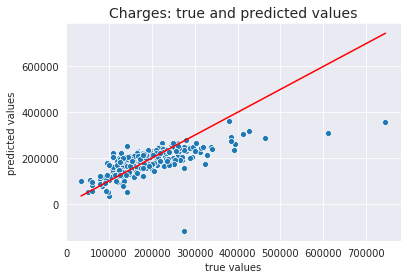

Mean absolute error (MAE) of the prediction is: 38197.10212480276
Mean squared error (MSE) of the prediction is: 3409922109.812413
Root mean squared error (RMSE) of the prediction is: 58394.53835601762
Mean absolute percentage error (MAPE) of the prediction is: 21.561275830242792


In [92]:
# Now we test the model!
# We need to manually add a constant in statsmodels' sm
X_test = sm.add_constant(X_test)

# Here is where we make our predictions
y_pred = results.predict(X_test)

sns.set_style('darkgrid')
sns.scatterplot(y_test,y_pred)
sns.lineplot(y_test,y_test, color='r')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values", size=14)
plt.show()

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_pred)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_pred)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_pred)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

In [71]:
y_pred.min()

-117634.1800711482

###  Is the performance of your model satisfactory? Why?
+ Although the MAPE is lower than the MAPE from the checkpoint tutrorial, we can tell from our $R^2$, as well as just inspecting the plot of the the prediction accuracy at higher values, that our model can use improvement.

### Try to improve your model in terms of predictive performance by adding or removing some variables.

In [133]:
# Adding new features, including 'grlivarea', 'garagearea', 'bedroomabvgr','yearbuilt' and 'fullbath' 
new_features = ['alley_Pave','poolqc_Fa','poolqc_Gd','poolqc_NoPo','garagetype_Attchd','garagetype_BuiltIn', 'grlivarea',
                'garagetype_NoGa','lotarea','totalbsmtsf','garagearea', 'bedroomabvgr','yearbuilt','fullbath']

X = houses_df_dummies[new_features]
Y = houses_df_dummies.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# Don't forget to add a constant
X_train = sm.add_constant(X_train
                         )
# Let's train our new model
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     253.3
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:34:09   Log-Likelihood:                -14038.
No. Observations:                1168   AIC:                         2.810e+04
Df Residuals:                    1154   BIC:                         2.817e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.202e+06   1.21e+05     -9.962      0.000   -1.44e+06   -9.65e+05
alley_Pave         -2742.8293   7324.308     -0.374      0.708   -1.71e+04    1.16e+04
poolqc_Fa          -1.293e-06   1.19e-07    -10.840      0.000   -1.53e-06   -1.06e-06
poolqc_Gd          -2.431e+05      5e+04     -4.858      0.000   -3.41e+05   -1.45e+05
poolqc_NoPo          6.17e+04   4.07e+04      1.515      0.130   -1.82e+04    1.42e+05
garagetype_Attchd   9286.0806   3315.988      2.800      0.005    2780.039    1.58e+04
garagetype_BuiltIn  1.893e+04   6227.183      3.040      0.002    6712.289    3.11e+04
grlivarea             80.6000      3.895     20.694      0.000      72.958      88.242
garagetype_NoGa     1.321e+04   6569.288      2.011      0.045     319.608    2.61e+04
lotarea                0.4380      0.117      3.741      0.000       0.208       0.668
totalbsmtsf           34.2990      3.534      9.706      0.000      27.365      41.233
garagearea            65.8377      8.418      7.821      0.000      49.321      82.354
bedroomabvgr       -1.081e+04   1822.168     -5.933      0.000   -1.44e+04   -7235.123
yearbuilt            584.1647     59.421      9.831      0.000     467.579     700.751
fullbath            -580.2923   3191.278     -0.182      0.856   -6841.650    5681.066
==============================================================================
Omnibus:                      308.034   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18164.468
Skew:                           0.237   Prob(JB):                         0.00
Kurtosis:                      22.314   Cond. No.                     6.52e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.39e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

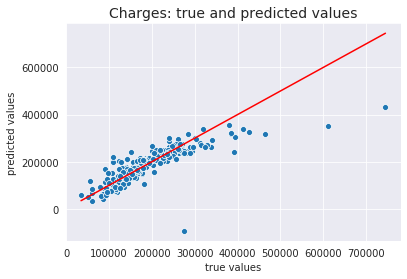

Mean absolute error (MAE) of the prediction is: 25488.835282763153
Mean squared error (MSE) of the prediction is: 2015109883.4096148
Root mean squared error (RMSE) of the prediction is: 44889.97531085994
Mean absolute percentage error (MAPE) of the prediction is: 14.492972032863783


In [132]:
# Let's test our new model
X_test = sm.add_constant(X_test)

y_pred = results.predict(X_test)

sns.set_style('darkgrid')
sns.scatterplot(y_test,y_pred)
sns.lineplot(y_test,y_test, color='r')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values", size=14)
plt.show()

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_pred)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_pred)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_pred)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

###  Any improvements?

> Although the visual representation didn't seem to change much, the error stats show improvement across the board, not to mention the adjusted $R^2$ improved to almost 74% from 50%. The BIC also dropped from $2.889e+04$ to $2.817e+04$. Since the original model is a nested model of our second model, the higher F-statistic on our second model (up to $253.3$ from $147.4$) also confirms that our second model is better.